In [93]:
from __future__ import absolute_import, division, print_function
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import Adadelta, adam
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from time import time
from keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from IPython.display import SVG

#from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateSchedule
print(os.listdir("/Users/sakshigupta/Downloads/cell_images"))

['rs_Parasitized.npy', 'gs_Uninfected.npy', 'rs_Uninfected.npy', '.DS_Store', 'Parasitized', 'training.npy', 'hn_Parasitized.npy', 'gs_Parasitized.npy', 'Uninfected', 'testing.npy', 'hn_Uninfected.npy']


In [76]:
infected = os.listdir('/Users/sakshigupta/Downloads/cell_images/Parasitized/') 
uninfected = os.listdir('/Users/sakshigupta/Downloads/cell_images/Uninfected/')

In [77]:
data=[]
labels=[]

#load images
def loadImages(path):
    image_files= os.listdir(path)
    return image_files

#Data Preprocessing
def preprocessing(path):
    image_files=loadImages(path)
    print(len(image_files))
    for i in image_files:
        try:
            image = cv2.imread(path +i)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            rotated45 = resize_img.rotate(45)
            rotated75 = resize_img.rotate(75)
            blur = cv2.blur(np.array(resize_img) ,(10,10))
            #Uncomment to do segmentation
            #gray_img= cv2.cvtColor(blur,cv2.COLOR_RGB2GRAY)
            #ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            #Append labels 0 for uninfected; 1 for infected
            if "Uninfected" in path:
                labels.append(0)
            else: 
                labels.append(1)
            data.append(np.array(rotated75))
        except AttributeError:
            print('aa')   
    return data

# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [78]:
image_path_uninfected="/Users/sakshigupta/Downloads/cell_images/Uninfected/"
image_path_parasitized="/Users/sakshigupta/Downloads/cell_images/Parasitized/"
imageArrayUninfected= preprocessing(image_path_uninfected)
imageArrayTotal= preprocessing(image_path_parasitized)

13780
aa
13780
aa


In [79]:
len(imageArrayTotal)

27558

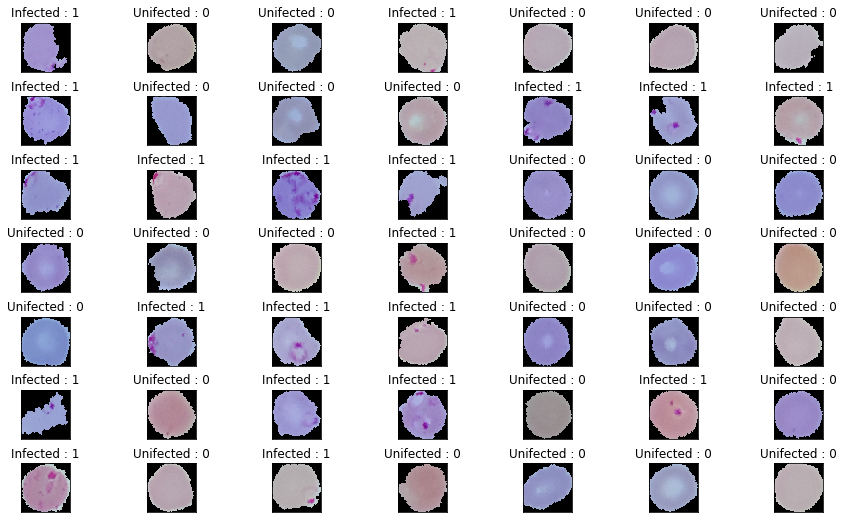

In [80]:
#Convert to np array
cells = np.array(data)
labels = np.array(labels)
np.save('Cells' , cells)
np.save('Labels' , labels)

plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

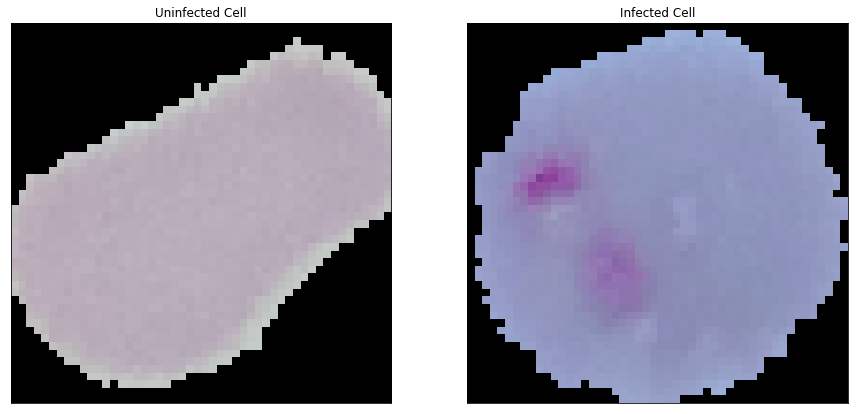

In [81]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[1])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[26000])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [82]:
#Shuffle the dataset
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

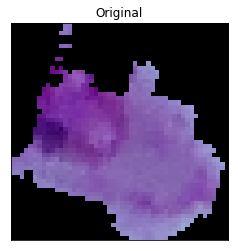

In [83]:
display_one(cells[10])

In [84]:
from sklearn.model_selection import train_test_split

x_train , x , y_train , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

x_eval , x_test , y_eval , y_test = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [85]:
num_classes=len(np.unique(labels))
len_data=len(cells)

In [86]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [87]:
y_train[1000]

array([1., 0.], dtype=float32)

In [120]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 6, 6, 64)          0         
__________

In [102]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [104]:
#Fit the model with min batch size as 50[can tune batch size to some factor of 2^power ] 




history= model.fit(x_train,y_train, validation_data=(x_test, y_test), batch_size=50,epochs=1,verbose=1, callbacks=[checkpoint,tensorboard,csvlogger,reduce])




Train on 22046 samples, validate on 2756 samples
Epoch 1/1
22046/22046 [==============================] - 65s 3ms/step - loss: 0.4724 - acc: 0.7631 - val_loss: 0.1898 - val_acc: 0.9394

Epoch 00001: val_loss improved from inf to 0.18976, saving model to ./base.model


In [105]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

2756/2756 [==============================] - 2s 629us/step

 Test_Accuracy:- 0.9394049346879536


In [118]:
#model 2
def ConvBlock(model1, layers, filters,name):
    for i in range(layers):
        model1.add(SeparableConv2D(filters, (3, 3), activation='relu',name=name))
        model1.add(BatchNormalization())
        model1.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCN():
    model1 = Sequential()
    model1.add(Lambda(lambda x: x, input_shape=(50, 50, 3)))
    ConvBlock(model1, 1, 64,'block_1')
    ConvBlock(model1, 1, 128,'block_2')
    ConvBlock(model1, 1, 256,'block_3')
    ConvBlock(model1, 1, 512,'block_4')
    model1.add(Flatten())
    model1.add(Dense(1024,activation='relu'))
    model1.add(Dropout(0.5))
    model1.add(Dense(2,activation='sigmoid'))
    return model1

model1 = FCN()
model1.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 50, 50, 3)         0         
_________________________________________________________________
block_1 (SeparableConv2D)    (None, 48, 48, 64)        283       
_________________________________________________________________
batch_normalization_21 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
block_2 (SeparableConv2D)    (None, 22, 22, 128)       8896      
_________________________________________________________________
batch_normalization_22 (Batc (None, 22, 22, 128)       512       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 11, 11, 128)       0         
__________

In [115]:
# compile the model with loss as categorical_crossentropy and using Adadelta optimizer you can test result by trying RMSProp as well as Momentum
model1.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

In [116]:
#Fit the model with min batch size as 50[can tune batch size to some factor of 2^power ] 




history= model1.fit(x_train,y_train, validation_data=(x_test, y_test), batch_size=50,epochs=1,verbose=1, callbacks=[checkpoint,tensorboard,csvlogger,reduce])



Train on 22046 samples, validate on 2756 samples
Epoch 1/1
22046/22046 [==============================] - 469s 21ms/step - loss: 0.3747 - acc: 0.8280 - val_loss: 0.1855 - val_acc: 0.9296

Epoch 00001: val_loss did not improve from 0.17756


In [117]:
accuracy = model1.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

2756/2756 [==============================] - 11s 4ms/step

 Test_Accuracy:- 0.9296081277213353


In [19]:
y_pred = model.predict(x_test)

In [20]:
#Reverse one hot encoding
from numpy import argmax
y_pred_conv = np.argmax(y_pred, axis=-1)
y_test_conv = np.argmax(y_test, axis=-1)

In [21]:
import pandas as pd
frame = pd.DataFrame(y_pred_conv,y_test_conv)
frame[:14]

,0
0,0
1,1
1,1
1,1
1,1
1,1
0,0
1,1
1,1
0,0


In [22]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1381   46]
 [  97 1232]]


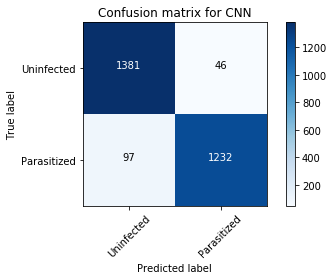

In [25]:
conf_matrix_CNN= confusion_matrix(y_test_conv,y_pred_conv)
plot_confusion_matrix(conf_matrix_CNN, classes= my_tags,
                      title='Confusion matrix for CNN')

In [26]:
# Classification Report 
my_tags = ['Uninfected','Parasitized']
print(metrics.classification_report(y_test_conv, y_pred_conv,target_names=my_tags))

              precision    recall  f1-score   support

  Uninfected       0.93      0.97      0.95      1427
 Parasitized       0.96      0.93      0.95      1329

   micro avg       0.95      0.95      0.95      2756
   macro avg       0.95      0.95      0.95      2756
weighted avg       0.95      0.95      0.95      2756



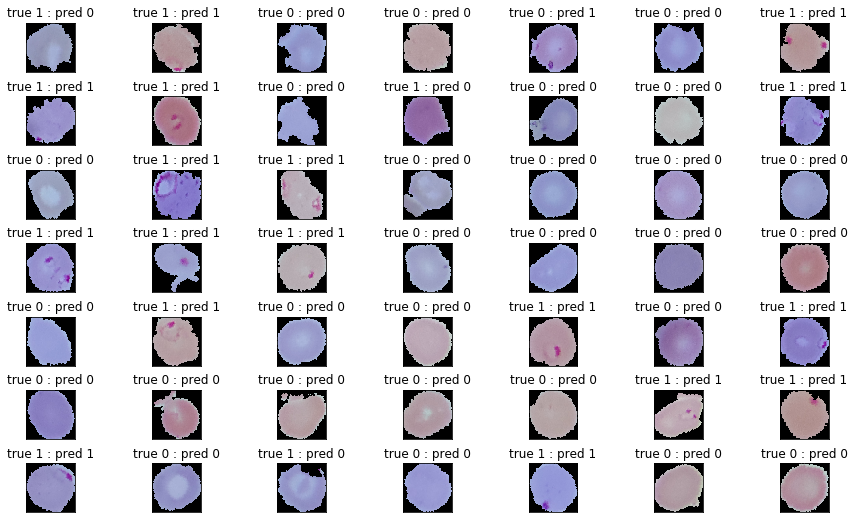

In [27]:
#Error Analysis
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , x_test.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(x_test[r[0]])
    plt.title('true {} : pred {}'.format(y_test_conv[r[0]] , y_pred_conv[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()


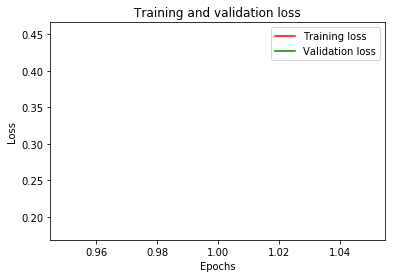

In [28]:
#Evaluation
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

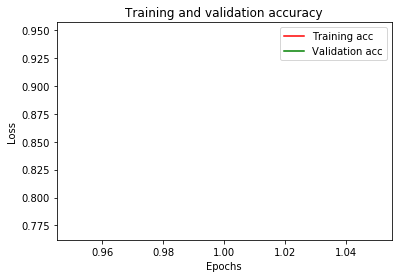

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
#Visualization of output at each layer for x_train[22000]
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[22000].reshape(1,50,50,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
        

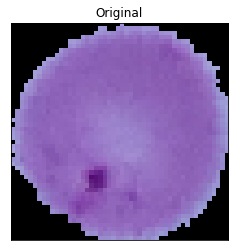

In [31]:
display_one(x_train[22000])

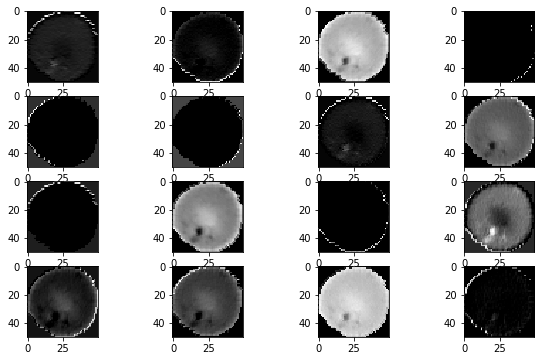

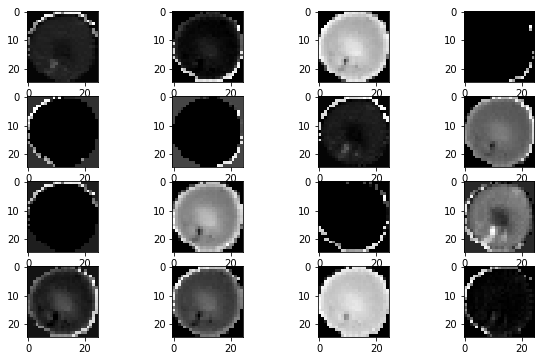

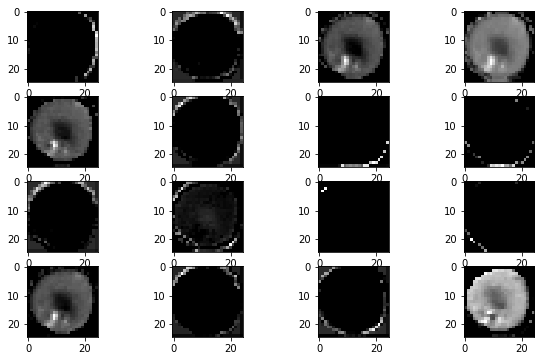

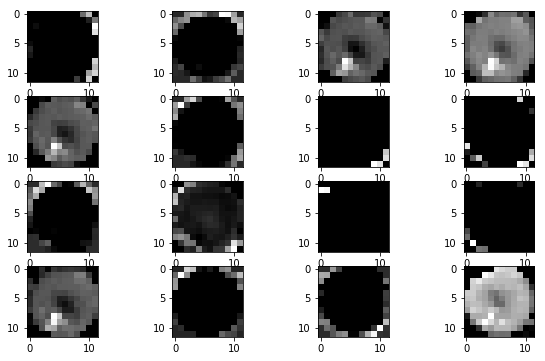

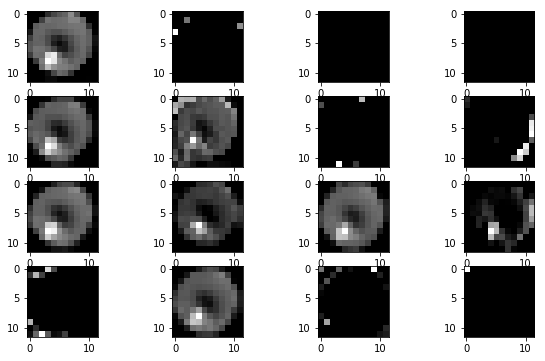

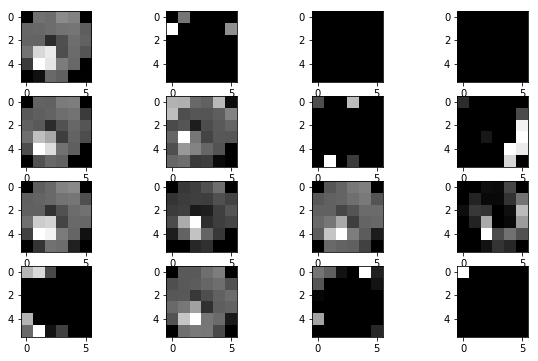

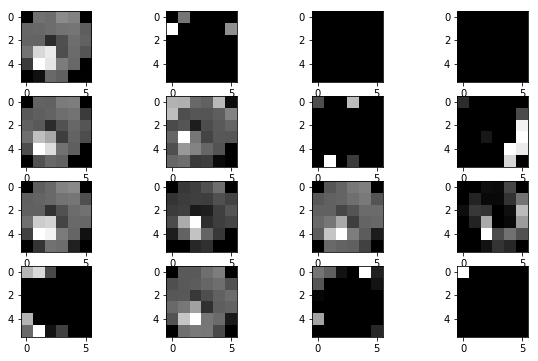

In [32]:
display_activation(activations, 4, 4, 0)
display_activation(activations, 4, 4, 1)
display_activation(activations, 4, 4, 2)
display_activation(activations, 4, 4, 3)
display_activation(activations, 4, 4, 4)
display_activation(activations, 4, 4, 5)
display_activation(activations, 4, 4, 6)




In [35]:
#Neural n/w visualization
from ann_visualizer.visualize import ann_viz;
ann_viz(model, title="Malaria detection neural network")

In [38]:
import keras;
from keras.models import Sequential;
from keras.layers import Dense;

network = Sequential();
        #Hidden Layer#1
network.add(Dense(units=6,
                  activation='relu',
                  kernel_initializer='uniform',
                  input_dim=11));

        #Hidden Layer#2
network.add(Dense(units=6,
                  activation='relu',
                  kernel_initializer='uniform'));

        #Exit Layer
network.add(Dense(units=1,
                  activation='sigmoid',
                  kernel_initializer='uniform'));

from ann_visualizer.visualize import ann_viz;

ann_viz(network, title="");

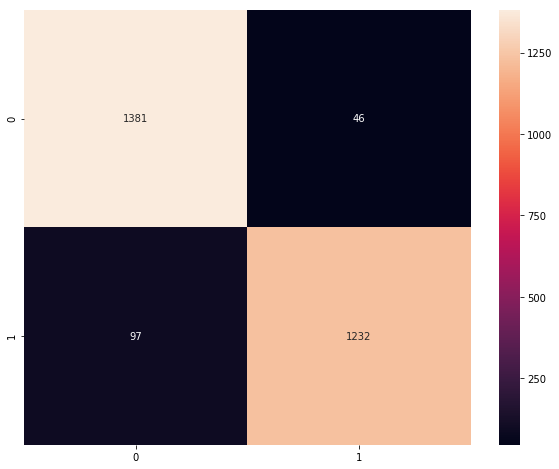

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_CNN, annot=True, fmt="d");

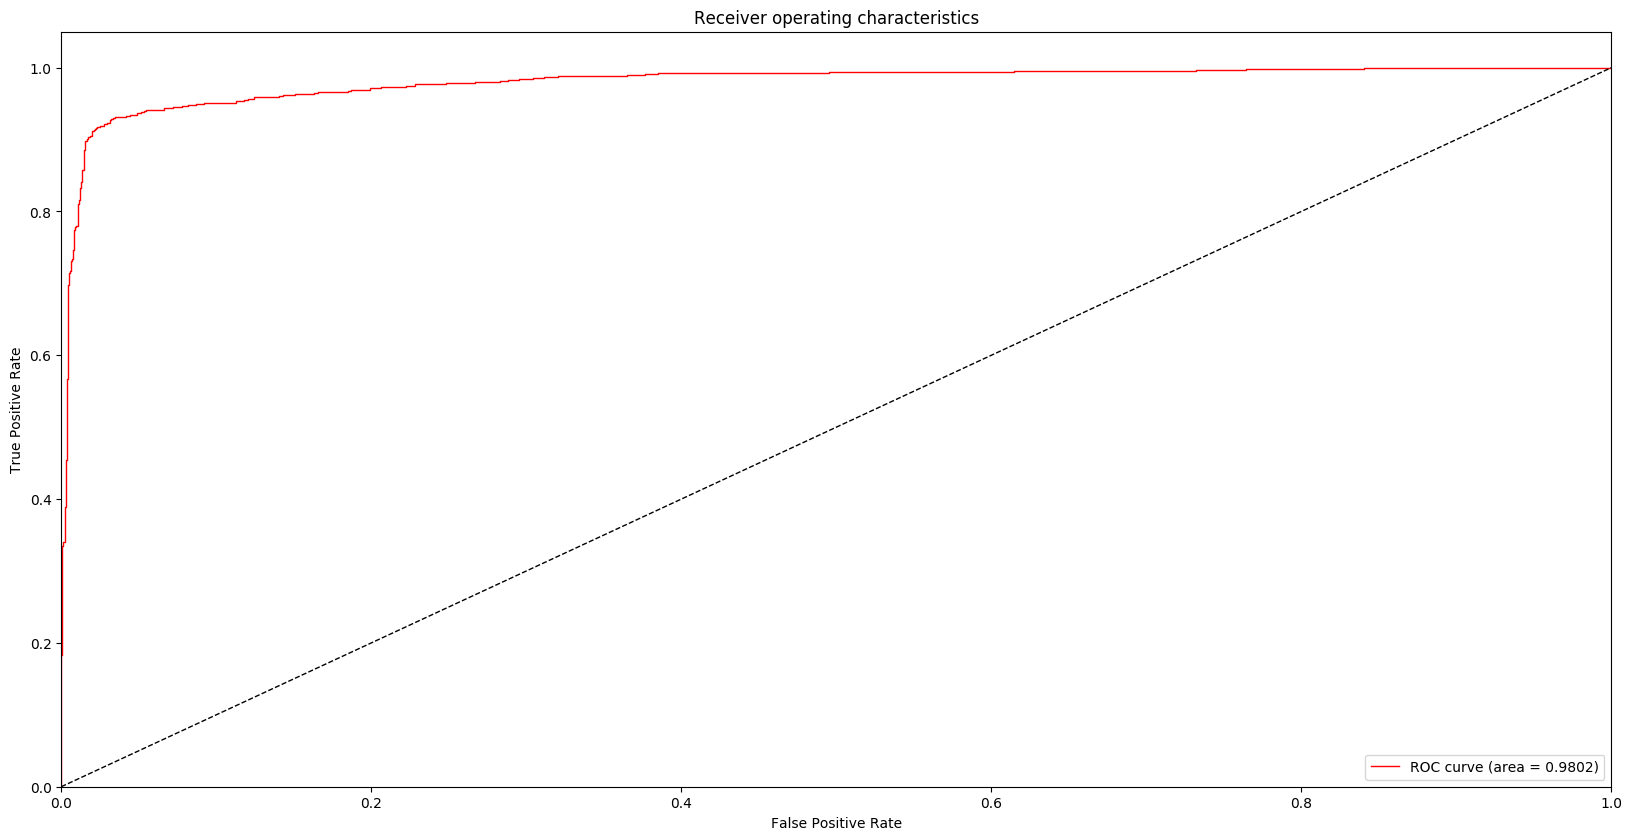

0.18186582533268494
0.9795169828969829
[0 1 1 ... 0 0 1]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [57]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
%matplotlib inline

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot ROC curves
plt.figure(figsize=(20,10), dpi=100)
lw = 1
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

# computhe the cross-entropy loss score
score = log_loss(y_test,y_pred)
print(score)

# compute the average precision score
prec_score = average_precision_score(y_test,y_pred)  
print(prec_score)

# transfer it back
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_test, axis=1)
print(y_pred)
print(y_test)

#save the predictions as a CSV file for further analysis
np.savetxt('custom_model_y_pred.csv',y_pred,fmt='%i',delimiter = ",")
np.savetxt('custom_model_Y_test.csv',y_test,fmt='%i',delimiter = ",")